# **ML Model Training & Evaluation**

**✨ Cross‑Environment Compatibility Statement (Polished Version)**

This hands‑on demo was built and tested in Microsoft Fabric, but every step uses standard Apache Spark APIs. That means you can run the exact same code in any Spark‑compatible environment, including Databricks, Synapse Spark, AWS EMR, Google Dataproc, or a local Spark cluster. No Fabric‑specific libraries or features are required.

As long as your environment supports:
- Apache Spark (PySpark)
- Standard DataFrame operations
- Basic file I/O to a supported storage location

In [2]:
# Load cleaned housing dataset into a Spark DataFrame
df_selling_housing = spark.read.csv(
    # Path to the cleaned regression housing CSV folder
    "Files/csv/ml/cleaned/regression_housing_cleaned",
    header=True,          # Use first row as column headers
    inferSchema=True      # Automatically detect column data types
)

# Preview a small sample of the dataset
display(df_selling_housing.limit(5))

# Inspect full schema to verify structure and data types
df_selling_housing.printSchema()

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 4, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a5d7f7df-e4e8-4fe4-a1c0-a5e659ba860a)

root
 |-- beds: double (nullable = true)
 |-- baths: double (nullable = true)
 |-- sqft: double (nullable = true)
 |-- built_year: double (nullable = true)
 |-- lot_acres: double (nullable = true)
 |-- has_garage: integer (nullable = true)
 |-- has_renovation: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- city_Arlington: double (nullable = true)
 |-- city_Boston: double (nullable = true)
 |-- city_Charlotte: double (nullable = true)
 |-- city_Denver: double (nullable = true)
 |-- city_Edison: double (nullable = true)
 |-- city_Fresno: double (nullable = true)
 |-- city_Grand Rapids: double (nullable = true)
 |-- city_Houston: double (nullable = true)
 |-- city_Idaho Falls: double (nullable = true)
 |-- city_Jacksonville: double (nullable = true)
 |-- neighborhood_Downtown: double (nullable = true)
 |-- neighborhood_Rural: double (nullable = true)
 |-- neighborhood_Suburban: double (nullable = true)



#### Splitting the dataset into training and testing sets
- In this code:
    - `train_test_split`: This function from the `sklearn.model_selection` module is used to split arrays or matrices into random train and test subsets.
    - `X`: The features (independent variables).
    - `y`: The target (dependent variable).
    - `test_size=0.30`: This parameter specifies that 30% of the data should be used for the test set, and the remaining 70% will be used for the training set.
    - `random_state=0`: This parameter ensures reproducibility of the split. Using the same random_state value will always produce the same split.
    -  **Resulting Variables**:
        - `X_train`: The training set features.
        - `X_test`: The test set features.
        - `y_train`: The training set target.
        - `y_test`: The test set target.

In [3]:
from sklearn.model_selection import train_test_split

df_selling_housing = df_selling_housing.toPandas()

# Split the dataset into training and testing sets
# The data is split into two sets: 70% for training and 30% for testing
train, test = train_test_split(df_selling_housing, test_size=0.3, random_state=0)

# Print the number of rows in the training and testing sets
# This helps to verify the split and ensure that the data is divided as expected
print("Training Rows:", len(train), "Testing Rows:", len(test))

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 5, Finished, Available, Finished)

Training Rows: 700 Testing Rows: 300


#### Features & Target Selection
- In this code:
    - `X` contains the features (independent variables) from the dataframe df, specifically the columns "beds", "baths", "sqft", "built_year", "lot_acres", "has_garage", "has_renovation".
    - `y` contains the target (dependent variable) from the column ‘price’ in the dataframe df.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume df_selling_housing is already defined

# Define feature columns (all except 'price')
feature_cols = [
    "beds", "baths", "sqft", "built_year", "lot_acres", "has_garage",
    "has_renovation",
    # city one-hot columns
    "city_Arlington", "city_Boston", "city_Charlotte", "city_Denver",
    "city_Edison", "city_Fresno", "city_Grand Rapids", "city_Houston",
    "city_Idaho Falls", "city_Jacksonville",
    # neighborhood one-hot columns
    "neighborhood_Downtown", "neighborhood_Rural", "neighborhood_Suburban"
]

# Target column
label_col = "price"

# =========================
# Feature selection: Extract the features (independent variables)
# =========================
X_train = train[feature_cols].values
X_test  = test[feature_cols].values

# =========================
# Target selection: Extract the target (dependent variable)
# =========================
y_train = train[label_col].values
y_test  = test[label_col].values

print('Feature and target selection done')
print("Training Rows:", len(X_train), "Testing Rows:", len(X_test))

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 6, Finished, Available, Finished)

Feature and target selection done
Training Rows: 700 Testing Rows: 300


#### Model experiment tracking with MLflow
Model experiment tracking is essential in several areas of machine learning and data science.

Purpose:
- `Experiment Tracking`: By setting an experiment, you can organize and track all related runs, metrics, parameters, and artifacts under a single experiment name. This makes it easier to manage and compare different runs.
- `Reproducibility`: Ensures that all runs are associated with a specific experiment, making it easier to reproduce and analyze results.
- `Collaboration`: Facilitates collaboration by providing a centralized place to track and share experiment results with team members.

In [5]:
# Import the MLflow library
import mlflow

# Define the name of the experiment
experiment_name = "selling-houseing-exp-job"

# Set the experiment in MLflow
mlflow.set_experiment(experiment_name)

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 7, Finished, Available, Finished)

<Experiment: artifact_location='sds://onelakeeastus.pbidedicated.windows.net/f79f6078-8af7-4029-8721-f620bb80e877/8c7f3ed2-2e18-433e-880d-db9a7f947039', creation_time=1768009421668, experiment_id='8c7f3ed2-2e18-433e-880d-db9a7f947039', last_update_time=1768009421668, lifecycle_stage='active', name='selling-houseing-exp-job', tags={}>

## **Trains a regression model using Linear Regression**
- Additionally, you’re logging a parameter called **estimator** with the value **LinearRegression**

In [6]:
# Import the LinearRegression class from scikit-learn
from sklearn.linear_model import LinearRegression

# Enable automatic logging of parameters, metrics, and models with MLflow
mlflow.autolog()

# Start an MLflow run
with mlflow.start_run():
    # Initialize the LinearRegression model
    model = LinearRegression()
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Log a custom parameter to MLflow
    mlflow.log_param("estimator", "LinearRegression")

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 8, Finished, Available, Finished)

2026/01/11 16:06:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/01/11 16:06:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


##### **Trains a regression model using Decision Tree Regressor**
- Additionally, you’re logging a parameter called **estimator** with the value **DecisionTreeRegressor**.

In [7]:
# Import the DecisionTreeRegressor class from scikit-learn
from sklearn.tree import DecisionTreeRegressor

# Enable automatic logging of parameters, metrics, and models with MLflow
mlflow.autolog()

# Start an MLflow run
with mlflow.start_run():
    
    # Initialize the DecisionTreeRegressor model with a maximum depth of 5
    model = DecisionTreeRegressor(max_depth=5)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Log a custom parameter to MLflow
    mlflow.log_param("estimator", "DecisionTreeRegressor")

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 9, Finished, Available, Finished)

2026/01/11 16:06:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


#### Comparing the performance of LinearRegression vs DecisionTreeRegressor

In [8]:
# Define the name of the experiment
#experiment_name = "experiment-diabetes"

# Retrieve the experiment details by its name
exp = mlflow.get_experiment_by_name(experiment_name)

# Print the experiment details
print(exp)

# Search for all runs in the specified experiment
mlflow.search_runs(exp.experiment_id)

# Search for the most recent two runs in the specified experiment, ordered by start time in descending order
runs_df = mlflow.search_runs(exp.experiment_id, order_by=["start_time DESC"], max_results=2)

# Select only the important columns for model comparison
metrics_df = runs_df[[
    "run_id",
    "status",
    "start_time",
    "end_time",
    "tags.estimator_name",
    "metrics.training_score",
    "metrics.training_mean_absolute_error",
    "metrics.training_r2_score",
    "metrics.training_mean_squared_error"
]]

metrics_df

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 10, Finished, Available, Finished)

<Experiment: artifact_location='sds://onelakeeastus.pbidedicated.windows.net/f79f6078-8af7-4029-8721-f620bb80e877/8c7f3ed2-2e18-433e-880d-db9a7f947039', creation_time=1768009421668, experiment_id='8c7f3ed2-2e18-433e-880d-db9a7f947039', last_update_time=1768009421668, lifecycle_stage='active', name='selling-houseing-exp-job', tags={}>


,run_id,status,start_time,end_time,tags.estimator_name,metrics.training_score,metrics.training_mean_absolute_error,metrics.training_r2_score,metrics.training_mean_squared_error
0,eb071e09-c49a-4e3c-81ce-ab997130aa45,FINISHED,2026-01-11 16:06:50.015000+00:00,2026-01-11 16:06:54.687000+00:00,DecisionTreeRegressor,0.756769,86211.340723,0.756769,1.293200e+10
1,962a6a63-5c02-4714-98a0-491a6f31e719,FINISHED,2026-01-11 16:06:29.471000+00:00,2026-01-11 16:06:41.370000+00:00,LinearRegression,0.896169,53739.165719,0.896169,5.520449e+09


StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 11, Finished, Available, Finished)

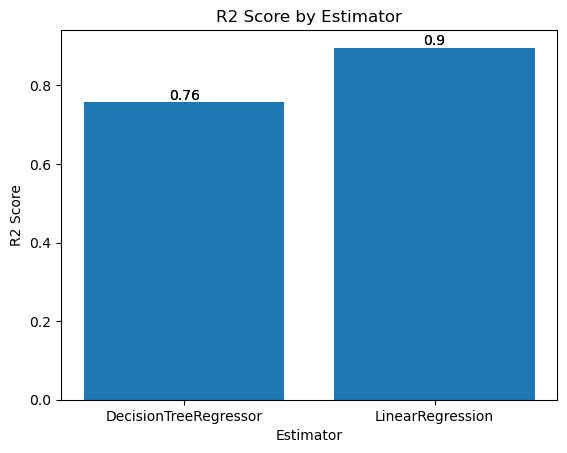

In [9]:
import matplotlib.pyplot as plt

# Assuming df_results contains the evaluation metrics for multiple models
df_results = mlflow.search_runs(exp.experiment_id, order_by=["start_time DESC"], max_results=5)[["metrics.training_r2_score", "params.estimator"]]

# Create a bar plot to visualize the R2 scores by estimator
fig, ax = plt.subplots()
bars = ax.bar(df_results["params.estimator"], df_results["metrics.training_r2_score"])

# Add labels above each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax.set_xlabel("Estimator")
ax.set_ylabel("R2 Score")
ax.set_title("R2 Score by Estimator")

# Display the plot
plt.show()

#### Register the model
- Why Register the Model?
    - `Version Control`: By registering the model, you can keep track of different versions, making it easier to manage updates and rollbacks.
    - `Deployment`: Registered models can be easily deployed to production environments, ensuring consistency and reliability.
    - `Reproducibility`: Ensures that the exact version of the model used in experiments can be reproduced.
    - `Collaboration`: Provides a centralized repository where team members can access and work with the same models.

In [10]:
# Get the most recent experiment run
exp = mlflow.get_experiment_by_name(experiment_name)
last_run = mlflow.search_runs(exp.experiment_id, order_by=["start_time DESC"], max_results=2)
last_run_id = last_run.iloc[1]["run_id"]

# Register the model that was trained in that run
print("Registering the model from run:", last_run_id)

model_uri = "runs:/{}/model".format(last_run_id)

mv = mlflow.register_model(model_uri, "regression_selling_housing_demo")
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

StatementMeta(, 3cc5d09d-682d-4506-8dc7-9616fc85785c, 12, Finished, Available, Finished)

Registering the model from run: 962a6a63-5c02-4714-98a0-491a6f31e719


Successfully registered model 'regression_selling_housing_demo'.
Created version '1' of model 'regression_selling_housing_demo'.
